In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display
from scipy.stats import mannwhitneyu, wilcoxon

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from lib.gallegosalas.data_fc_db import DataFCDatabase
from mesostat.metric.metric import MetricCalculator

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis


In [16]:
params = {}
# params['experiment_path']  = gui_fpath("Path to data collection",  './')
# params['experiment_path'] = '/media/alyosha/Data/TE_data/yasirdata/auditory_task_all_trials'
params['experiment_path'] = '/media/alyosha/Data/TE_data/yasirdata/tactile_task_all_trials'

In [17]:
dataDB = DataFCDatabase(params)

Target range of [20, 95] timesteps amounts to [1.0, 4.7, 'seconds']
Reading channel label file
Searching for data files


In [18]:
dataDB.read_neuro_files()
len(dataDB.dataNeuronal)

IntProgress(value=0, description='Read Neuro Data:', max=6)

6

# Mono-Regional Metrics

* Dynamic Regime
    * SNR - via AutoCorr[1]
    * Saturation regime - via phase-space scatter
    * Identify speed of evolution by estimating exp decay timescale for each dataset.
        - Find timescale that minimizes AutoCorr[1]
* Temporal structure
    * Individual temporal specificity (regions more active later vs earlier)
        - Test activity for each timestep vs cycle null model, plot significant bins
    * Individual temporal stability (how consistent is the activity over trials)
        - Test activity for each timestep vs cycle null model, plot -log(p) for ranksum
* Specificity to external observables (movement, action, learning)
    - Test activity for each timestep for hit/miss, (separate naive/expert)
    - Scatter temporal mean vs performance 

## 1.1 SNR via AutoCorrelation

**Plan:**
* AutoCorr[1] is a number that is close to 1 if data is changing slowly, and close to zero if data changes very fast.

doing mouse m15
doing mouse m18
doing mouse m5
doing mouse m6
doing mouse m7
doing mouse m9


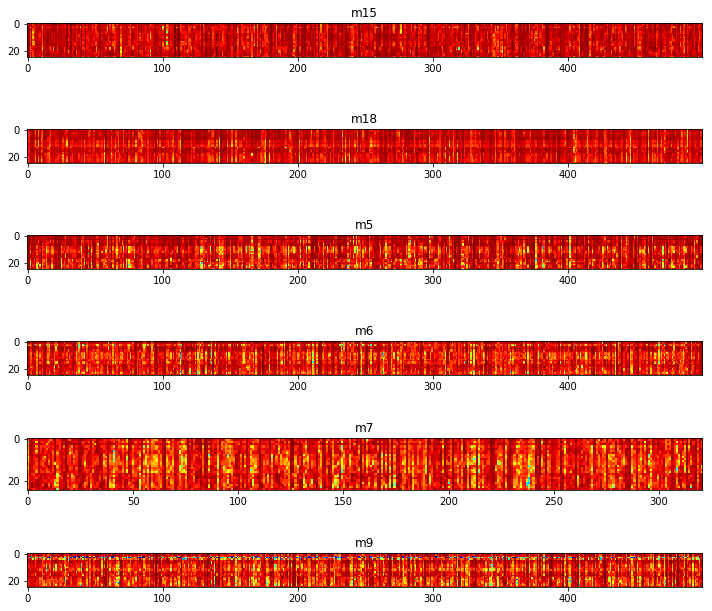

In [19]:
mc = MetricCalculator(serial=True, verbose=False)

fig, ax = plt.subplots(nrows=len(dataDB.mice), figsize=(10,1.5*len(dataDB.mice)), tight_layout=True)
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    print('doing mouse', mousename)
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    rez = []
    for idx, row in rows.iterrows():
        mc.set_data(dataDB.dataNeuronal[idx], 'rsp', zscoreDim=None)
        rez += [mc.metric3D('autocorr_d1', 'rp', metricSettings=None, sweepSettings=None)]
        
    rez = np.concatenate(rez, axis=0)
        
    ax[iMouse].set_title(mousename)
    ax[iMouse].imshow(np.array(rez).T, cmap='jet', vmin=0, vmax=1)
plt.show()

# 2. Temporal Structure
## 2.1 Temporal specificity

In [6]:
pool.terminate()
pool.join()

NameError: name 'pool' is not defined

doing mouse m15
..got session; took time 0.14133214950561523


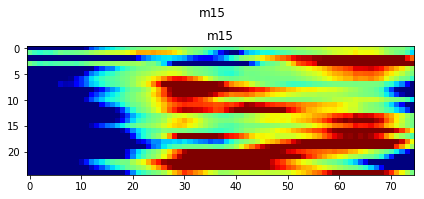

doing mouse m18
..got session; took time 0.14610815048217773


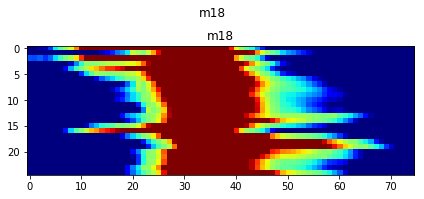

doing mouse m5
..got session; took time 0.1605052947998047


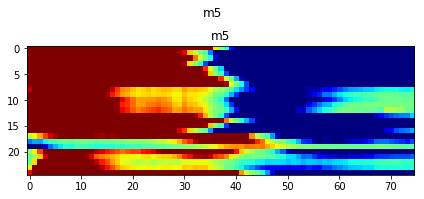

doing mouse m6
..got session; took time 0.1669471263885498


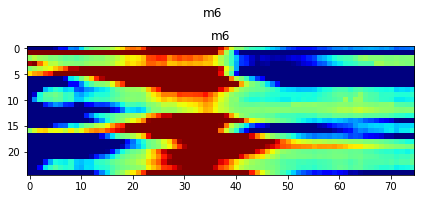

doing mouse m7
..got session; took time 0.14861464500427246


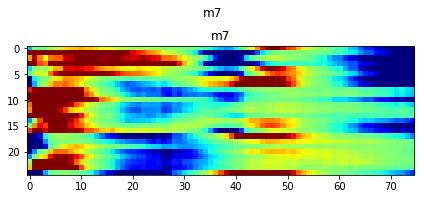

doing mouse m9
..got session; took time 0.16637635231018066


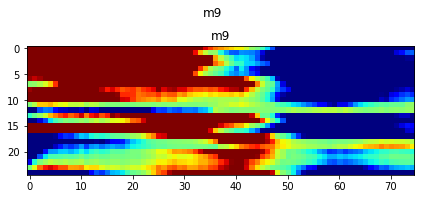

In [20]:
import multiprocessing
from time import time

def task2(data2D):
    dataTmp = data2D - np.nanmean(data2D)
    
    nTime = data2D.shape[1]
    rez = np.full(nTime, np.nan)

    for iTime in range(nTime):
        dataNonNan = dataTmp[:, iTime][~np.isnan(dataTmp[:, iTime])]
        
        if len(dataNonNan > 10):        
            meanTime = np.mean(dataNonNan)
            T, pval = wilcoxon(dataNonNan)
    #         rez[iTime] = np.sign(meanTime) * int(pval < 0.01 / nTime)
            rez[iTime] = np.sign(meanTime) * (-np.log10(pval))
            
    return rez
    

# Parallel stuff
pool = multiprocessing.Pool(processes=4)

for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    print('doing mouse', mousename)
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    fig, ax = plt.subplots(ncols=len(rows), figsize=(6*len(rows), 3), tight_layout=True, squeeze=False)
    fig.suptitle(mousename)
    
    for iPlot, (idx, row) in enumerate(rows.iterrows()):
        print('..got session', end='')
        timeStart = time()

        data = dataDB.dataNeuronal[idx]
        dataTmp = data.transpose((2,0,1))
        rez = np.array(pool.map(task2, dataTmp))

#         ax[iPlot].imshow(rez, vmin=-1.1, vmax=1.1, cmap='jet')
        ax[0][iPlot].imshow(rez, vmin=-10, vmax=10, cmap='jet')
        ax[0][iPlot].set_title(mousename)

        print('; took time', time() - timeStart)
    plt.show()
    
pool.terminate()
pool.join()

# 3. Behaviour-Specific performance

## 3.1 Temporal mean vs learning

doing mouse m15


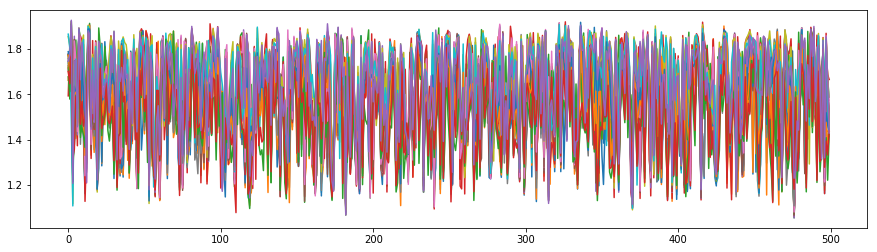

doing mouse m18


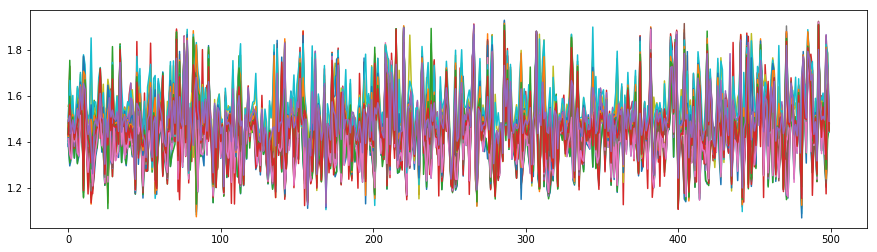

doing mouse m5


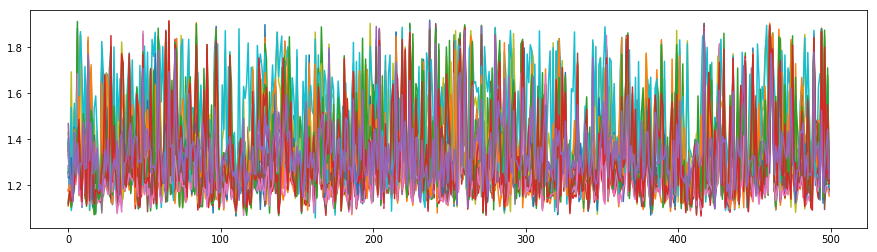

doing mouse m6


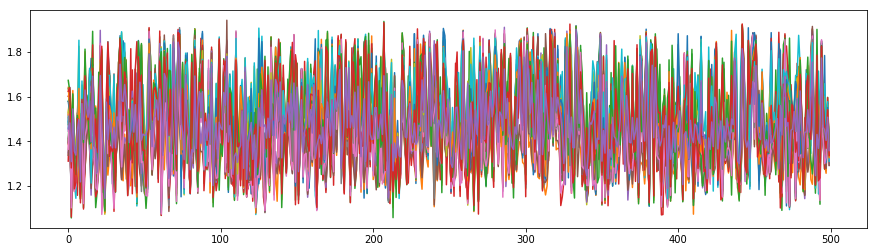

doing mouse m7


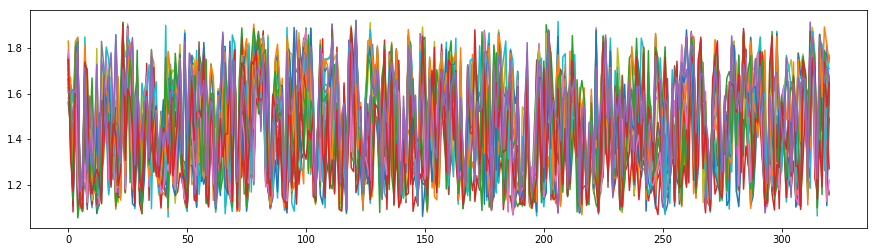

doing mouse m9


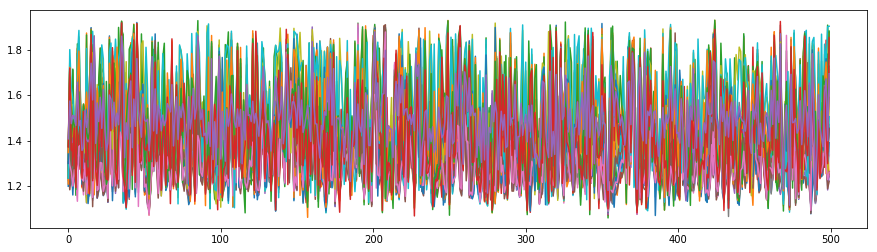

In [21]:
rez = {}
for mousename in sorted(dataDB.mice):
    print('doing mouse', mousename)
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    for idx, row in rows.iterrows():
        mc.set_data(dataDB.dataNeuronal[idx], 'rsp', zscoreDim=None)
        rezThis = mc.metric3D('ord_mean', 'pr', metricSettings=None, sweepSettings=None)

        fig, ax = plt.subplots(figsize=(15,4))
        for rezChannel in rezThis:
            ax.plot(rezChannel)
    
        plt.show()